# 네이버 뉴스 기사 데이터 텍스트 분석 (워드클라우드)
- 임산별 | 2025.07.24


### 1. 네이버 뉴스 크롤링 코드

In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import pandas as pd

In [ ]:
# 1. chrome 브라우저 실행
path = "/Users/sanbyeol/Desktop/Data_analysitic/chromedriver-mac-x64 2/chromedriver"
service = webdriver.chrome.service.Service(path)
driver = webdriver.Chrome(service=service)


#driver = webdriver.Chrome(service=service, options=options)


url = "https://search.naver.com/search.naver?ssc=tab.news.all&query=%22%EC%B2%AD%EB%85%84%20%EC%B7%A8%EC%97%85%20%EC%A7%80%EC%9B%90%EA%B8%88%22&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds=2023.01.01&de=2024.12.31&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom20230101to20241231&is_sug_officeid=0&office_category=0&service_area=0"
driver.get(url)

# 스크롤
for _ in range(30):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1.5)

# 뉴스 제목 span 태그 수집
title_spans = driver.find_elements(By.CSS_SELECTOR, 'span.sds-comps-text-type-headline1')
print(f"[INFO] 수집된 뉴스 개수: {len(title_spans)}")

results = []
for span in title_spans:
    try:
        parent_a = span.find_element(By.XPATH, "..")
        title = span.text.strip()
        link = parent_a.get_attribute("href")
        results.append({"title": title, "link": link})
    except Exception as e:
        continue

driver.quit()



In [ ]:
#저장
#df.to_csv('news_title_2023_2024.csv')

________________

### 2. 텍스트 데이터 전처리

- 이스케이프 문자 / 숫자 / 특수문자 제거 
- 영어 : 대소문자 제거 

In [ ]:
# 1. 라이브러리 import
import re
from nltk.corpus import stopwords
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [23]:
# 2.데이터 load
df = pd.read_csv('news_title_2023_2024.csv')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  310 non-null    int64 
 1   title       310 non-null    object
 2   link        310 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.4+ KB


뉴스 기사 제목 수 : 310개 

In [25]:
clean_data = pd.DataFrame(df['title'])

In [26]:
# 1. 특수문자,공백 제거 

r_symbol = re.compile('\W+') #특수문자
r_strip = re.compile(r'\W+') #공백제거
clean_data['clean'] = clean_data['title'].apply(lambda x : re.sub("\n|\t", " ", x ) )
clean_data['clean'] = clean_data['clean'].apply(lambda x : r_symbol.sub(' ', x))
clean_data['clean'] = clean_data['clean'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())


<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/var/folders/3g/tlt8qmcx1nj7kqtx38v8dw380000gn/T/ipykernel_8506/2289560175.py:3: SyntaxWarning: invalid escape sequence '\W'
  r_symbol = re.compile('\W+') #특수문자


In [27]:
# 알파벳 대소문자는 소문자로 통일

clean_data['clean'] = clean_data['clean'].apply(lambda x : x.lower() )


____________

In [29]:
# 2. 토큰화 및 품사 태깅 

#konlpy import
from konlpy.tag import Okt
okt = Okt()

# 형태소 분석 및 토큰화 
#명사만 추출하는 함수
def extract_nouns(text):
    return okt.nouns(text)

# 명사, 형용사, 동사만 추출하는 함수
def token_tagging(text):
    tagged = okt.pos(text, stem=True)  # 품사 태깅 + 원형 복원
    return [word for word, tag in tagged if tag in ['Noun', 'Verb', 'Adjective']]


#전체 품사 태깅 함수
def tagging_pos(text):
    return okt.pos(text)



clean_data['all'] = clean_data['clean'].apply(token_tagging)
clean_data['nouns'] = clean_data['clean'].apply(extract_nouns)


In [31]:
clean_data[:2]

,title,clean,all,nouns
0,육아휴직급여 월 최대 250만원으로 인상…대체인력 지원금 확대,육아휴직급여 월 최대 250만원으로 인상 대체인력 지원금 확대,"[육아휴직, 급여, 월, 최대, 인상, 체인, 원금, 확대]","[육아휴직, 급여, 월, 최대, 인상, 체인, 원금, 확대]"
1,"[유통가 레이더] 'K-베이커리 노하우 전수'... CJ푸드빌, 청년 채용 확대...",유통가 레이더 k 베이커리 노하우 전수 cj푸드빌 청년 채용 확대,"[유통, 레이더, 베이커리, 노하우, 전수, 푸드, 빌다, 청년, 채용, 확대]","[유통, 레이더, 베이커리, 노하우, 전수, 푸드, 청년, 채용, 확대]"


In [32]:
# 불용어 제거 
stopwords = ['원금', '시책', '박승원', '병태', '강범석', '기탁', '이하', '미스', '에쓰오일', '매치', '김성태', '김성제', '데이', '이재호', '의왕', '퍼스', '컬러', '원기준', '클리', '정인화']

tokens_series_all = pd.Series([
    token for tokens in clean_data['all']
    for token in tokens
    if len(token) > 1 and token not in stopwords
])
news_tokens_all = tokens_series_all.value_counts()

# 워드클라우드용 딕셔너리 생성
word_freq_all = news_tokens_all.to_dict()

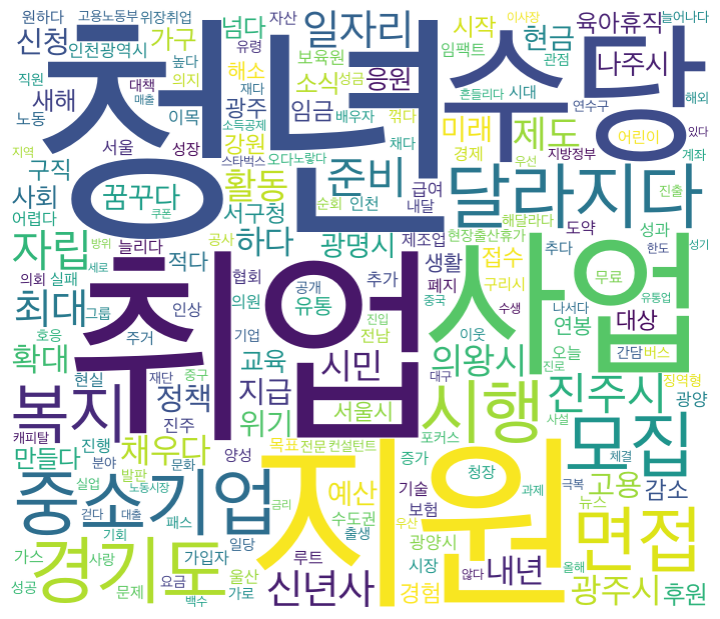

In [33]:
# 명사/형용사/동사 추출한 워드 클라우드 
wordcloud = WordCloud(
    font_path='/System/Library/Fonts/AppleSDGothicNeo.ttc',  # 한글 폰트 경로
    width=700,
    height=600,
    background_color='white',
    #color_func=pink_color_func,
    #colormap= 'spring', 
    #max_font_size=100,
    min_font_size = 7,
    max_words=200,
    relative_scaling=0.3,
    prefer_horizontal=1.0,
).generate_from_frequencies(word_freq_all)


# 시각화
plt.figure(figsize=(10, 6))
#plt.title("네이버 뉴스 '청년 취업 지원' 검색 결과_명사만")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


------------